<div style="text-align: center; font-size: 40px;">
    <b>Final Project</b>
    <br>
    Exploration of the Dodgers dataset
    <br>
    
</div>

In [1]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


Let's test our library code on the `dodgers` dataset from the TSB anomaly detection repo available here : 


 Dataset link : https://www.thedatum.org/datasets/TSB-UAD-Public.zip

### **Utilities**

In [2]:
def plot_sequences_with_labels(sequences, labels, num_sequences=5):
    plt.figure(figsize=(15, num_sequences * 3))
    
    for i in range(min(num_sequences, len(sequences))):
        plt.subplot(num_sequences, 1, i + 1)
        plt.plot(sequences[i], label=f'Sequence {i+1} ({ "Anomalous" if labels[i] == 1 else "Normal" })', 
                 color='red' if labels[i] == 1 else 'blue')
        plt.title(f'Sub-Sequence {i+1} - {"Anomalous" if labels[i] == 1 else "Normal"}')
        plt.xlabel('Time Index')
        plt.ylabel('Value')
        plt.legend(loc='upper right')
        
    plt.tight_layout()
    plt.show()

In [3]:
def plot_roc_curve(method, test_labels, test_proba, k, ax):
    roc_auc = roc_auc_score(test_labels, test_proba)
    fpr, tpr, _ = roc_curve(test_labels, test_proba)
    ax.plot(fpr, tpr, label=f"{method} " + ": AUC = {:.2f}".format(roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{method}: {k}, ROC curve')
    ax.legend()
    ax.grid()


# Dataset Exploration (first look and Extracting subsequences)

In [4]:
folder_path = "../Data/TSB_UAD/TSB-UAD-Public/Dodgers"


df = pd.read_csv(os.path.join(folder_path, "101-freeway-traffic.test.out"), delimiter=',', header=None, names=['value', 'is_anomaly'])
df = df[df['value'] != -1].reset_index(drop=True)


- The dataset represents the **number of visitors** to the Los Angeles Dodgers baseball team **website**.
- The data contains a unique continuous time series with **2709** anomalous points out of the **47497** total points.
- Anomalies in this dataset correspond to unusual spikes or drops in web traffic, which could be due to events such as promotions, games, or external factors.

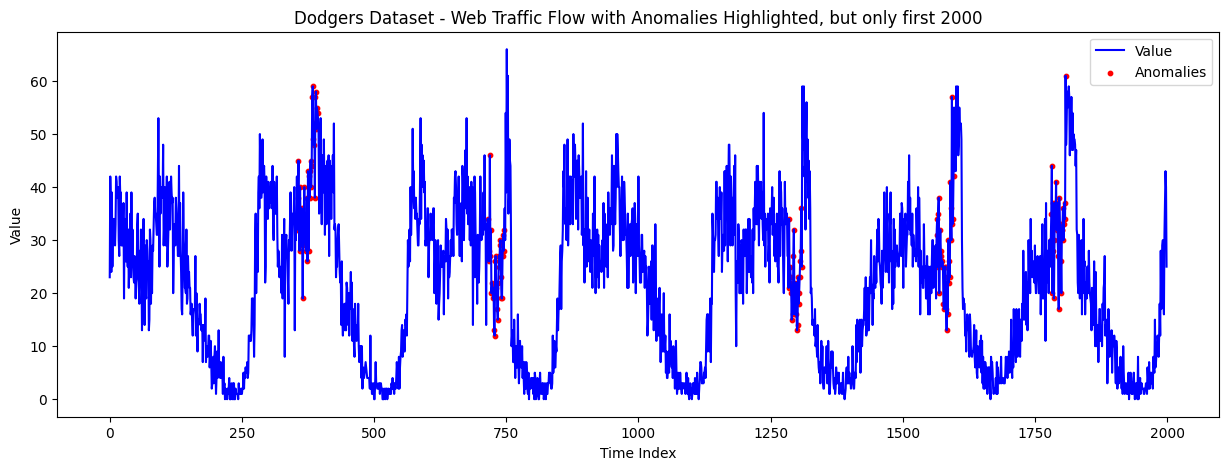

In [5]:
time_window = 2000
df_subset = df.iloc[:time_window]

plt.figure(figsize=(15, 5))
plt.plot(df_subset['value'], color='blue', label='Value')
anomalous_points = df_subset[df_subset['is_anomaly'] == 1]
plt.scatter(anomalous_points.index, anomalous_points['value'], color='red', s=10, label='Anomalies')

plt.xlabel('Time Index')
plt.ylabel('Value')
plt.title(f'Dodgers Dataset - Web Traffic Flow with Anomalies Highlighted, but only first {time_window}')
plt.legend()
plt.show()



We will transform the unique signal into mutliple sub-sequences of the same length by using a sliding window approach. After, each sub-sequence is labeled as either **anomalous** if it contains at least one anomaly point or **Normal** otherwise.


In [6]:
window_size = 200 
stride = 100

sequences = []
labels = []

for i in range(0, len(df) - window_size + 1, stride):
    sub_sequence = df.iloc[i:i + window_size]
    value_sequence = sub_sequence['value']
    anomaly_flag = int(sub_sequence['is_anomaly'].max() == 1)  # Check if any 'is_anomaly' in the window is 1
    sequences.append(value_sequence)
    labels.append(anomaly_flag)

print(f"Total sequences extracted: {len(sequences)}")
print(f"Label counts (0 = normal, 1 = anomalous): {np.unique(labels, return_counts=True)}")


Total sequences extracted: 473
Label counts (0 = normal, 1 = anomalous): (array([0, 1]), array([300, 173]))


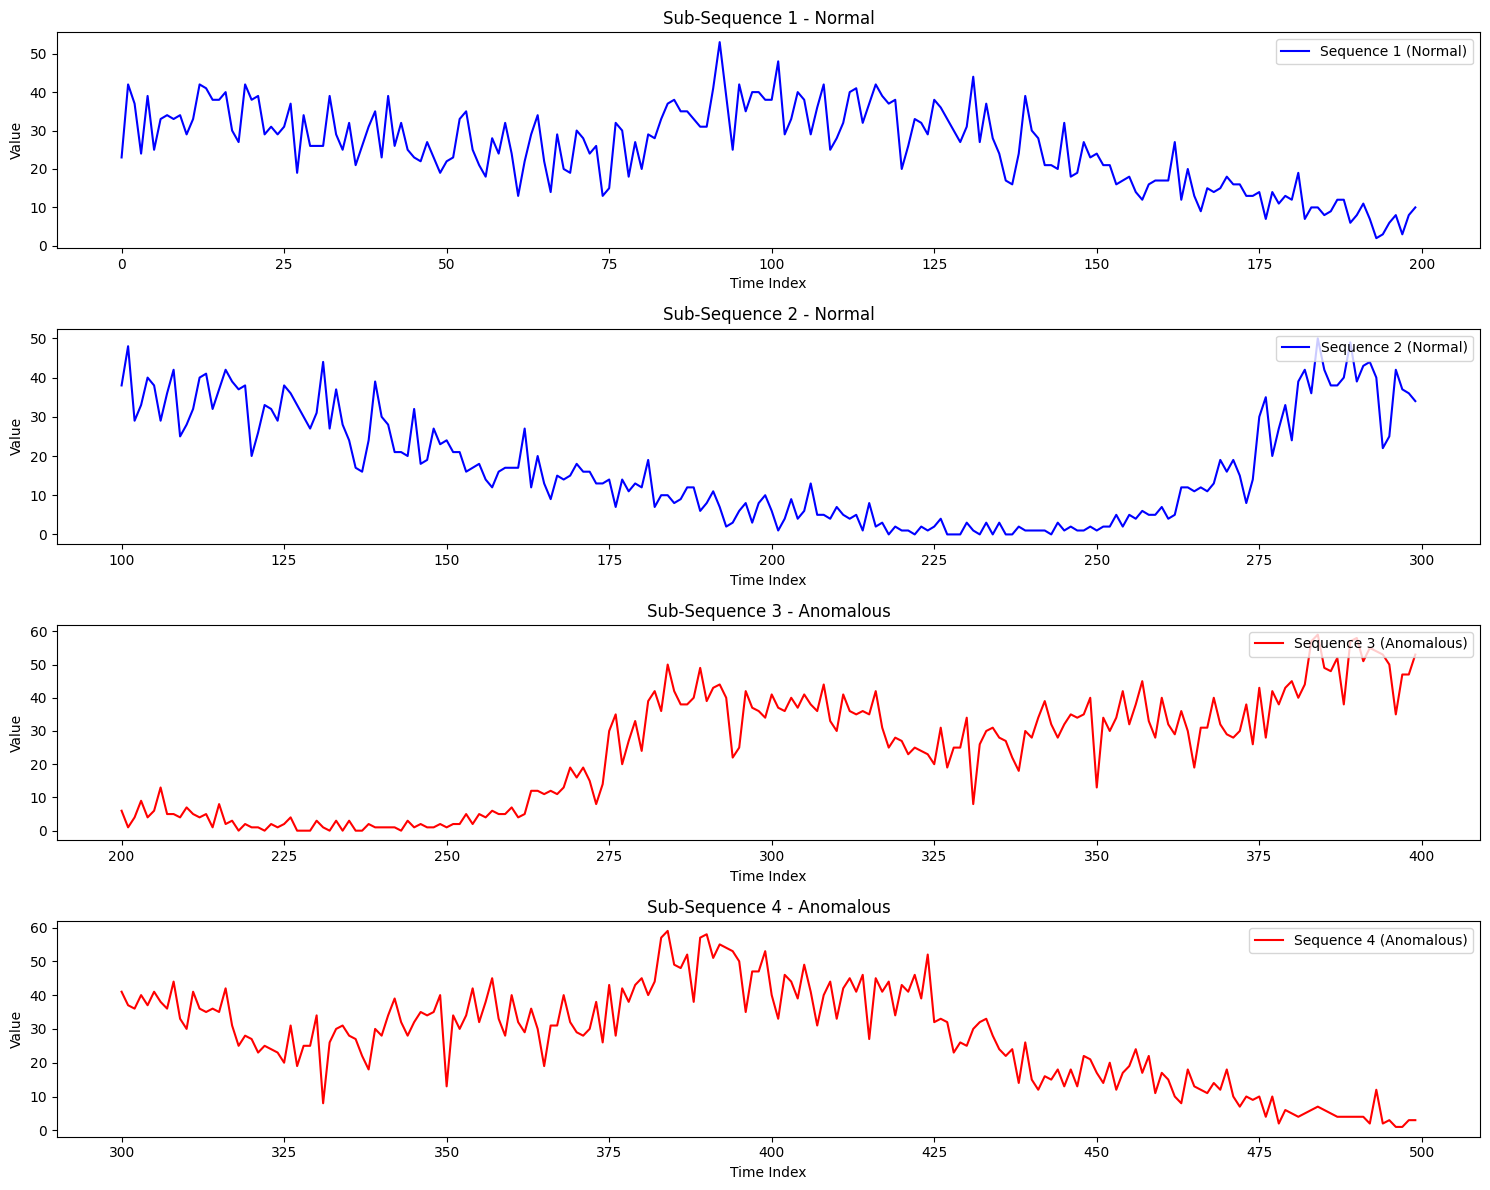

In [7]:
plot_sequences_with_labels(sequences, labels, 4)

# SAX algorithm : Transform the continuous signals into discrete sequences

Since the data is actually a dataset of continuous sequences, we will need transform it into a discrete sequence using the SAX method. Thankfully, we implemented a `SAX` class in opur library, that given a file, transform it into a labelised dataset of discrete sequences. There are two modes to this class, `local` and `global`, where `global` utilizes the values from the whole dataset of timeseries to assign the breakpoints for the sax method, whereas `local` only compute these values on the timeserie that is being transformed into a sylmbolic serie.

In [8]:
from utils import SAX, DataInspector
import os
import pandas as pd

In [9]:
sax = SAX(word_size=10, alphabet_size=7, mode="local")
df_clean = sax.read_file(os.path.join(folder_path, "101-freeway-traffic.test.out"))
print(f"Data loaded with {len(df_clean)} points.")

Data loaded with 47497 points.


In [10]:
dataset = sax.transform_with_sliding_windows(window_size=200, stride=100)

You can visualize a few of the sequences here, by adjusting the paramter of the `display_sequence` function.

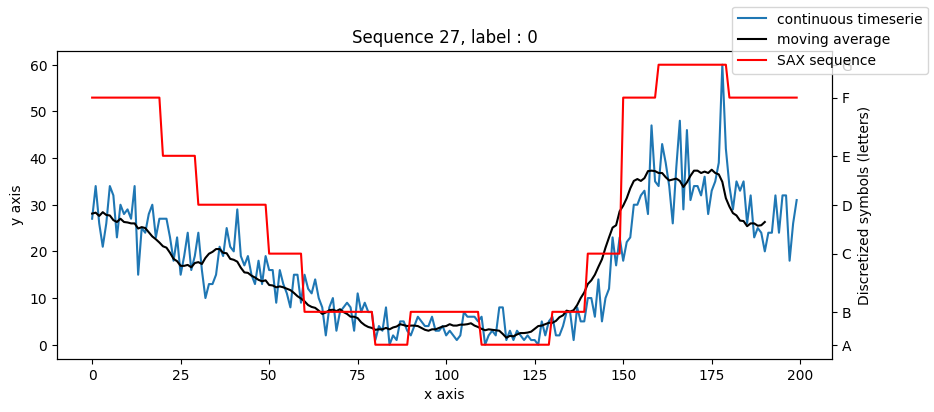

In [11]:
sax.display_sequence(27, display_moving_average=True)

## How did SAX transform the underlying data ? 

In this section, we examine how the SAX transformation impacted the separability of the two classes in the original dataset and we try to understand a bit better how the information is contained in our data using PCA.

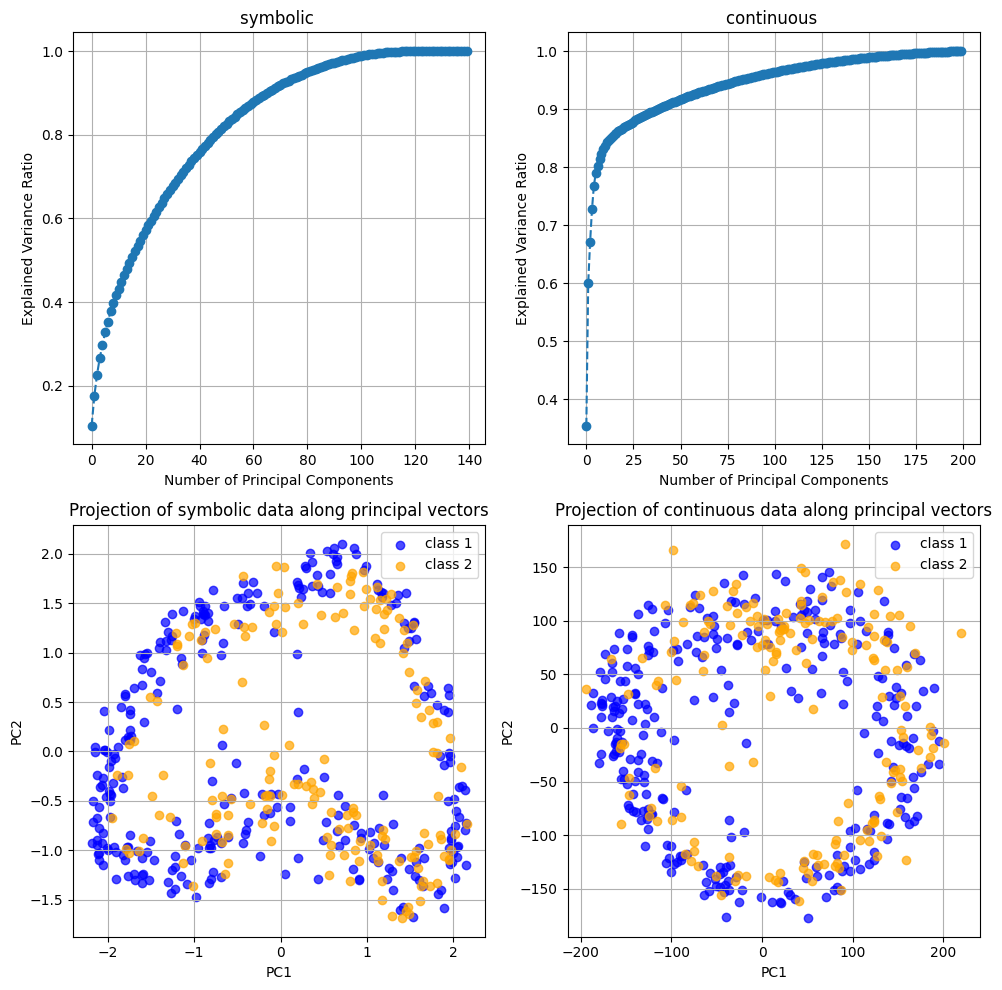

In [12]:
data_inspector = DataInspector(dataset)
data_inspector.display_pca(figsize=(10, 10))

We can clearly notice the difference in the information contained on the first components in both setups through the explained variance of the first principal components. 

## Separability Test :

One of the main problems we faced when using our models for anomaly detection, is how different the two classes of the continuous signal were to each other. So to understand our data better, we will check how well different models are able to separate the data. The two below methods compute the AUC score of a SVM trained on the dataset of continuous series versus the dataset of symbolic series.

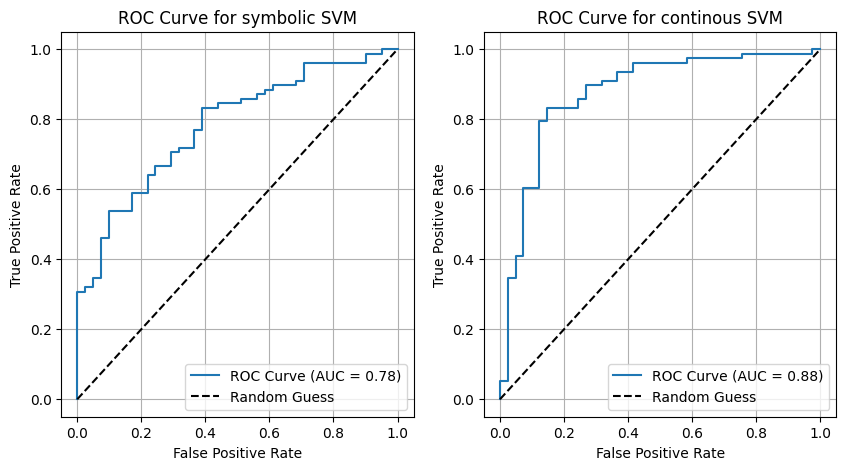

In [13]:
data_inspector.display_AUC_score(figsize=(10, 5))

From the above inspection, our data seems very separable using a classical SVM on the SAX-transformed data. But it also shows how the discretization does reduce the AUC score, so one should expect that some useful information originally contained in the initial segment was lost and will impact future performances. **However, let us remember that the classification problem, when one knows the category of the anomaly, is an easier problem than to infer anomalies from just one baseline class as was suggested in the article**.

# Benchmarking using the discretized sequences  

In the following section, we will test all the techniques implemented in our library against the SAX transformed dataset.

A reminder on the **Problem Definition** : 
- These methods rely on the training set being a set of "good" sequence, ie they serve as the baseline of what is considered normal. The anomalous data is not "seen" at training time, as it was suggested in section IV of the article. **This is a feature, not a bug**. This is why the anomaly detection problem is considerably harder than a classification one.    

For this, we split the dataset of the first part of the notebook in three. The "baseline" or "good" data is selected as one of the two class in the dataset. This selected class is then split into a training and a validation set. The second class in the original dataset is then considered as the anomaly class. 

In [14]:
baseline = dataset.loc[dataset["label"] == 0]
anomaly = dataset.loc[dataset["label"] == 1]

print(f"length category anomalous : {len(anomaly)} : length category normal : {len(baseline)}")

baseline_train = baseline.sample(frac=0.8, random_state=42)
baseline_validation = baseline.drop(baseline_train.index)
test_set = pd.concat([baseline_validation, anomaly])

baseline_validation = baseline_validation["sequence"].values
baseline_train = baseline_train["sequence"].values
test_labels = test_set['label'].values
test_set = test_set["sequence"].values

length category anomalous : 173 : length category normal : 300


## I) Kernel Based Techniques :

The Kernel based techniques rely on a kernel, which is a function that given two sequence returns a metric that express how similar they are to each other. In the article, two methods were proposed, one relying on a **KNearest algorithm** and one relying on **Medoids**. 


### Knearest Kernel
The training phase of a Knearest Kernel method is simply loading the dataset. To compute the anomaly score of a new serie, we will compute the kernel score of that sample against all the serie of our dataset, take the K-th smallest score and return the anomaly score as the inverse of that score. The training is therefore simply loading the dataset. Let's see it ! 

In [15]:
from KernelBased import KnearestKernel, nLCS

In [16]:
knearest_dad = KnearestKernel(nLCS, k_nearest=5)
knearest_dad.train(baseline_train)

test_proba = knearest_dad.predict_proba(test_set)

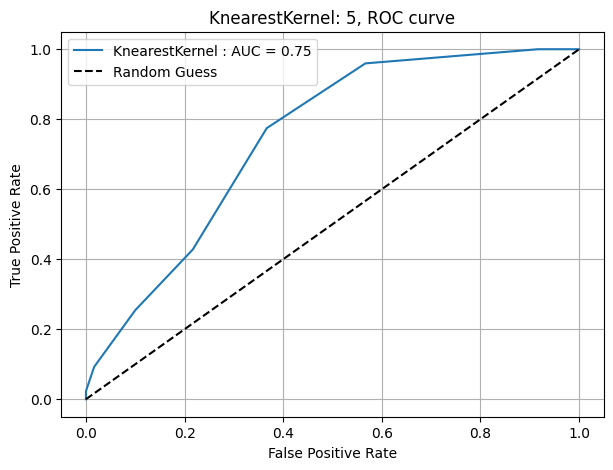

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve("KnearestKernel", test_labels, test_proba, 5, ax)

Now let us try this method for different value of K (the nearest sequence to compute anomaly score on) and evaluate the impact of K on the distribution of anomaly score on the test and validation set.

In [18]:
knearest_dad.set_knearest(1)
test_proba_1 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(3)
test_proba_3 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(7)
test_proba_7 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(15)
test_proba_15 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(30)
test_proba_30 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(100)
test_proba_100 = knearest_dad.predict_proba(test_set=test_set)

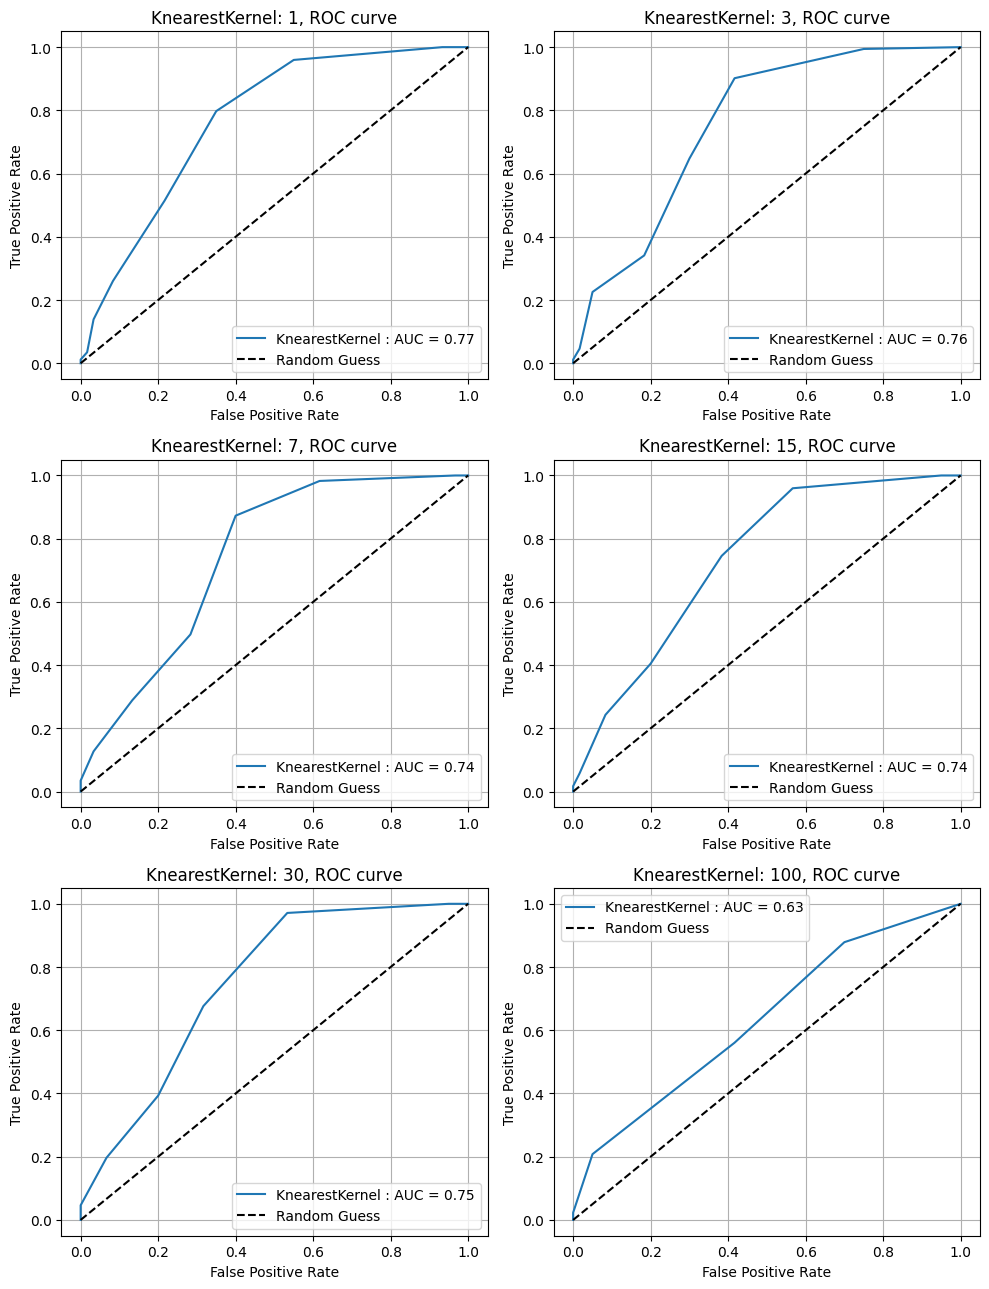

In [19]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(10)
fig.set_figheight(13)

plot_roc_curve("KnearestKernel", test_labels, test_proba_1, 1, ax1)
plot_roc_curve("KnearestKernel", test_labels, test_proba_3, 3, ax2)
plot_roc_curve("KnearestKernel", test_labels, test_proba_7, 7, ax3)
plot_roc_curve("KnearestKernel", test_labels, test_proba_15, 15, ax4)
plot_roc_curve("KnearestKernel", test_labels, test_proba_30, 30, ax5)
plot_roc_curve("KnearestKernel", test_labels, test_proba_100, 100, ax6)

fig.tight_layout()


Lower values of \( k \) appear to be more sensitive to local structures, while higher values risk over-generalization. But for lower values, we have the best performances.

At the end, the Knearest Kernel was very effictive in detecting anomalies in our dataset.


### Medoids Kernel
This method relies on computing a similarity matrix of all the sequence in our dataset at training time, and using this similarity matrix to find the Medoids in our dataset, ie the sequences that are most "like" the other sequences in our dataset. Once obtained, the anomaly score is assigned by giving the kernel distance between the sample data and the medoid that is closed to it. Let's see how it performs on real data ! 

In [20]:
from KernelBased import MedoidsKernel

In [21]:
kmedoids_dad = MedoidsKernel(nLCS)
kmedoids_dad.train(baseline_train)

test_proba = kmedoids_dad.predict_proba(test_set)
print(f"The optimal number of cluster found is : {len(kmedoids_dad.medoids)}")

The optimal number of cluster found is : 2


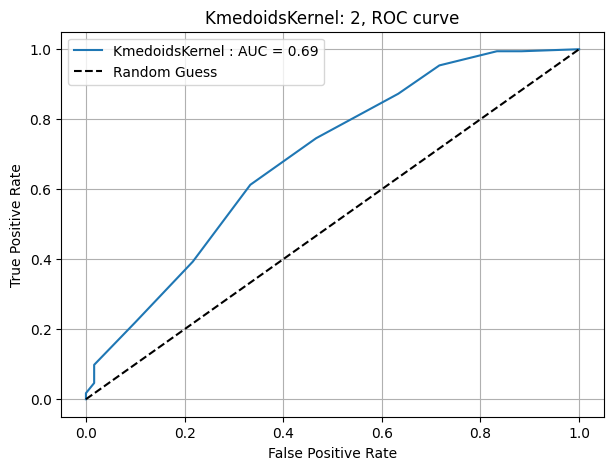

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve("KmedoidsKernel", test_labels, test_proba, 2, ax)

In [23]:
kmedoids_dad.set_new_medoids(3)
test_proba_3 = kmedoids_dad.predict_proba(test_set=test_set)

kmedoids_dad.set_new_medoids(5)
test_proba_5 = kmedoids_dad.predict_proba(test_set=test_set)

kmedoids_dad.set_new_medoids(7)
test_proba_7 = kmedoids_dad.predict_proba(test_set=test_set)

kmedoids_dad.set_new_medoids(10)
test_proba_10 = kmedoids_dad.predict_proba(test_set=test_set)

kmedoids_dad.set_new_medoids(20)
test_proba_20 = kmedoids_dad.predict_proba(test_set=test_set)


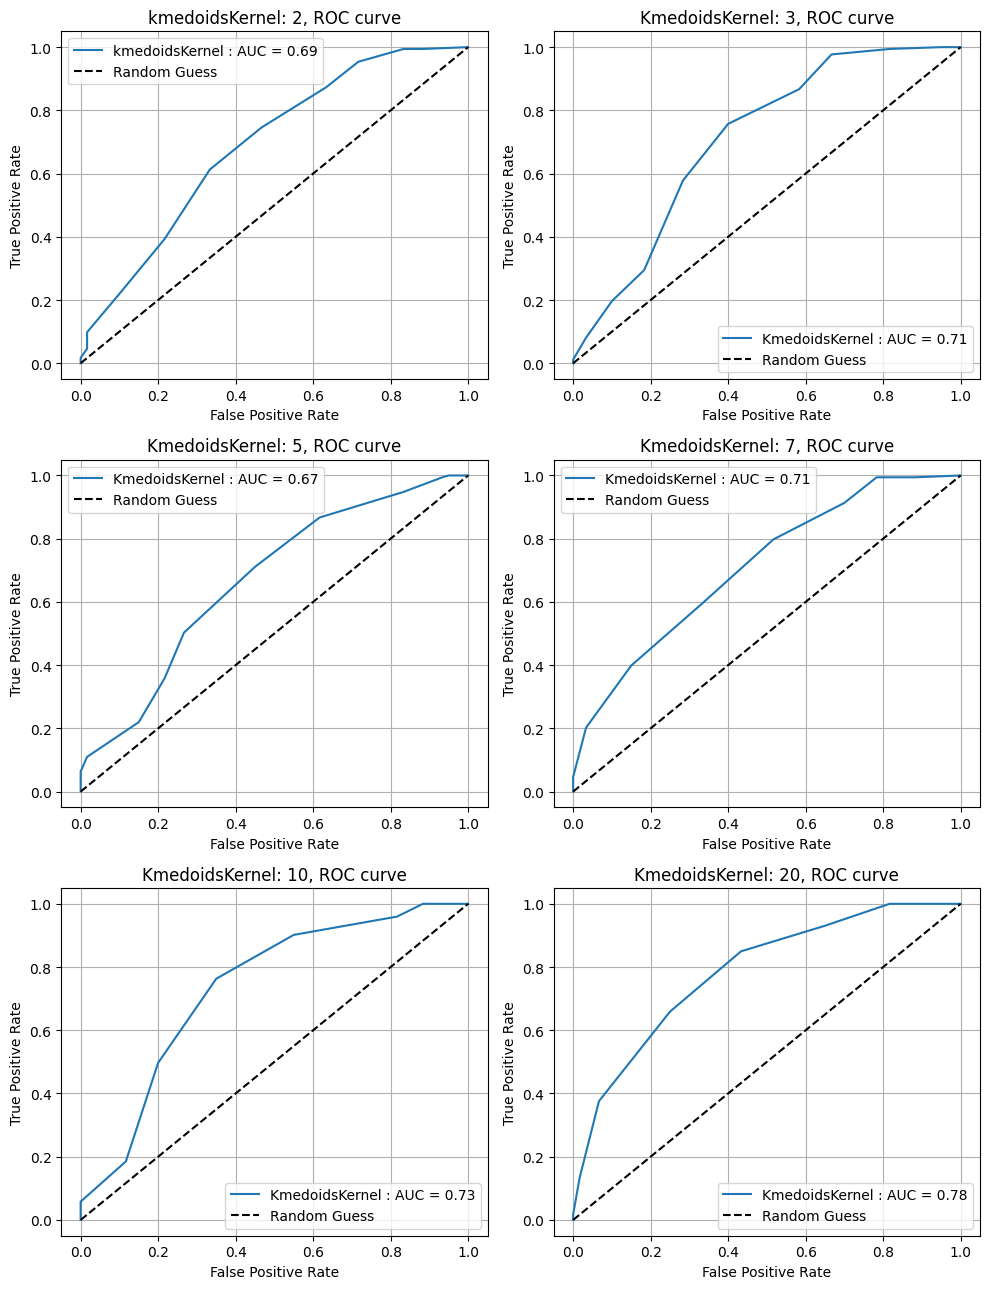

In [24]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(10)
fig.set_figheight(13)

plot_roc_curve("kmedoidsKernel", test_labels, test_proba, 2, ax1)
plot_roc_curve("KmedoidsKernel", test_labels, test_proba_3, 3, ax2)
plot_roc_curve("KmedoidsKernel", test_labels, test_proba_5, 5, ax3)
plot_roc_curve("KmedoidsKernel", test_labels, test_proba_7, 7, ax4)
plot_roc_curve("KmedoidsKernel", test_labels, test_proba_10, 10, ax5)
plot_roc_curve("KmedoidsKernel", test_labels, test_proba_20, 20, ax6)

fig.tight_layout()

The method shows promising anomaly detection capabilities, especially when using 7 to 20 medoids, where it achieves strong AUC scores. This method proves to be effective for our dataset

### Computation time : Kernel Methods : 

Knearest might be more interesting if the test sample during the lifetime of the algorithm is not larger than the training set, otherwise the Medoids based method quickly becomes more computationaly interesting, as the computation structure is split between a very high computation time at training (generating the similarity matrix) but an otherwise small computation time at testing, as we simply test against the medoids.

## Attempts on New Kernel :    

We decided to try different kernels other than the nLCS one and examine their results


In [25]:
from KernelBased import edit_distance_kernel

In [26]:
distance_DAD = MedoidsKernel(edit_distance_kernel)
distance_DAD.train(baseline_train)

test_proba = distance_DAD.predict_proba(test_set)
print(f"The optimal number of cluster found is : {len(kmedoids_dad.medoids)}")

The optimal number of cluster found is : 20


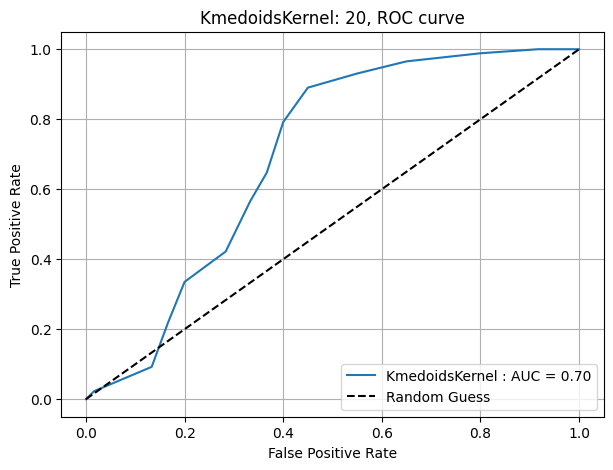

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve("KmedoidsKernel", test_labels, test_proba, 20, ax)

# II) Window Based Techniques :

In [28]:
from WindowBased import Lookahead, NormalDictionary, UnsupervisedSVM

In [29]:

lookahead = Lookahead(window_length=10)
lookahead.train(baseline_train)

test_proba = lookahead.predict_proba(test_set)

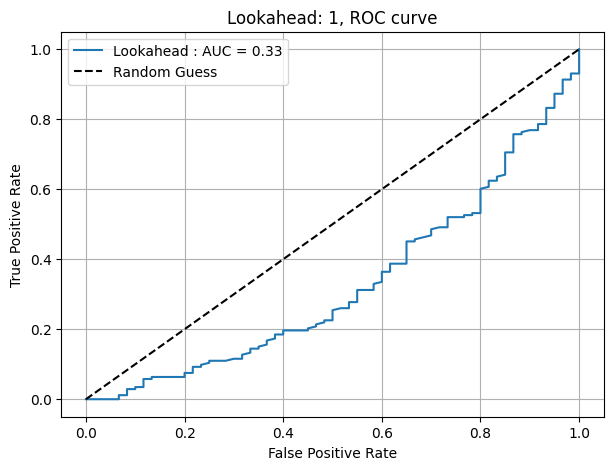

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve("Lookahead", test_labels, test_proba, 1, ax)

In [31]:
normal_dic = NormalDictionary(window_length=10)
normal_dic.train(baseline_train)

test_proba = normal_dic.predict_proba(test_set)

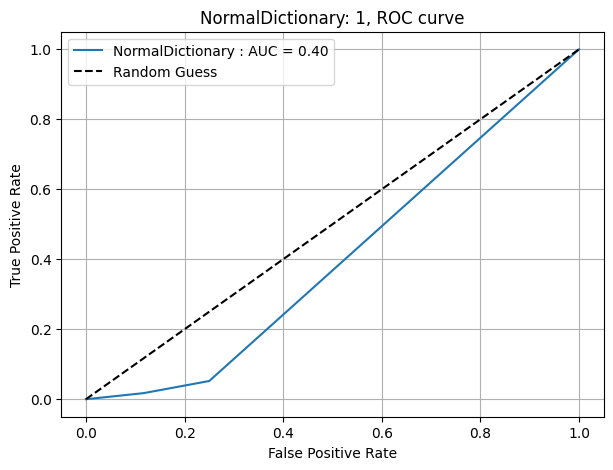

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve("NormalDictionary", test_labels, test_proba, 1, ax)

In [33]:
svm = UnsupervisedSVM(window_length=10)
svm.train(baseline_train)
test_proba = svm.predict_proba(test_set)

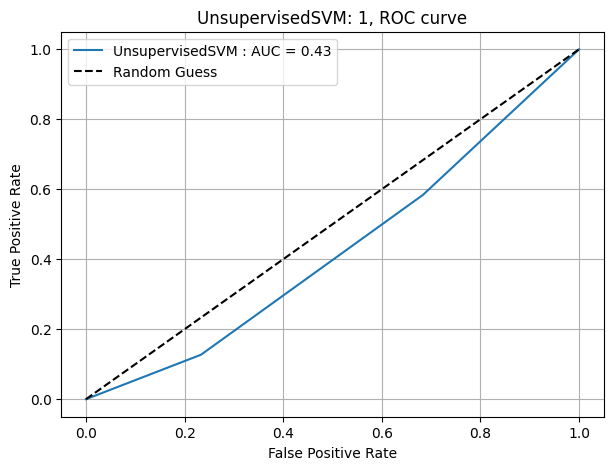

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve("UnsupervisedSVM", test_labels, test_proba, 1, ax)

The Window based perform poorly on our dataset, probably because of loss of long-term dependencies, and difficulty handling sparse or subtle anomalies

# SAX parameters and  influence on results

We decided to see the impact the parameters of the SAX algorithm have on the differents techniques. More precisely, we choosed different values of the alphabet size and the word size and ran the *K-nearest kernel method* since it was the one with the highest performance.

In [35]:
baseline = dataset.loc[dataset["label"] == 0]
anomaly = dataset.loc[dataset["label"] == 1]

print(f"length category anomalous : {len(anomaly)} : length category normal : {len(baseline)}")

baseline_train = baseline.sample(frac=0.8, random_state=42)
baseline_validation = baseline.drop(baseline_train.index)
test_set = pd.concat([baseline_validation, anomaly])

baseline_validation = baseline_validation["sequence"].values
baseline_train = baseline_train["sequence"].values
test_labels = test_set['label'].values
test_set = test_set["sequence"].values

length category anomalous : 173 : length category normal : 300


In [36]:
alphabet_sizes = [3, 5, 7, 10]  # Possible alphabet sizes
word_sizes = [5, 10, 20, 50]    # Possible word sizes

results = []

for alphabet_size in alphabet_sizes:
    for word_size in word_sizes:
        print(f"Running for Alphabet Size={alphabet_size}, Word Size={word_size}")
        
        # initialize and transform the dataset using SAX
        sax = SAX(word_size=word_size, alphabet_size=alphabet_size, mode="local")
        df_clean = sax.read_file(os.path.join(folder_path, "101-freeway-traffic.test.out"))
        dataset = sax.transform_with_sliding_windows(window_size=200, stride=100)
        
        # split into normal and anomalous sequences
        baseline = dataset.loc[dataset["label"] == 0]
        anomaly = dataset.loc[dataset["label"] == 1]
        
        baseline_train = baseline.sample(frac=0.8, random_state=42)
        baseline_validation = baseline.drop(baseline_train.index)
        test_set = pd.concat([baseline_validation, anomaly])

        baseline_validation = baseline_validation["sequence"].values
        baseline_train = baseline_train["sequence"].values
        test_labels = test_set['label'].values
        test_set = test_set["sequence"].values        

        knearest_dad = KnearestKernel(nLCS)
        knearest_dad.train(baseline_train)
        
        test_proba = knearest_dad.predict_proba(test_set)
        
        try:
            roc_auc = roc_auc_score(test_labels, test_proba)
        except ValueError as e:
            print(f"Error calculating ROC-AUC for Alphabet Size={alphabet_size}, Word Size={word_size}: {e}")
            roc_auc = 0

        print(f"ROC-AUC for Alphabet Size={alphabet_size}, Word Size={word_size}: {roc_auc:.4f}")
        
        results.append({
            'alphabet_size': alphabet_size,
            'word_size': word_size,
            'roc_auc': roc_auc
        })

df_performance = pd.DataFrame(results)


Running for Alphabet Size=3, Word Size=5
ROC-AUC for Alphabet Size=3, Word Size=5: 0.6878
Running for Alphabet Size=3, Word Size=10
ROC-AUC for Alphabet Size=3, Word Size=10: 0.7027
Running for Alphabet Size=3, Word Size=20
ROC-AUC for Alphabet Size=3, Word Size=20: 0.6475
Running for Alphabet Size=3, Word Size=50
ROC-AUC for Alphabet Size=3, Word Size=50: 0.5542
Running for Alphabet Size=5, Word Size=5
ROC-AUC for Alphabet Size=5, Word Size=5: 0.7031
Running for Alphabet Size=5, Word Size=10
ROC-AUC for Alphabet Size=5, Word Size=10: 0.6899
Running for Alphabet Size=5, Word Size=20
ROC-AUC for Alphabet Size=5, Word Size=20: 0.6719
Running for Alphabet Size=5, Word Size=50
ROC-AUC for Alphabet Size=5, Word Size=50: 0.5897
Running for Alphabet Size=7, Word Size=5
ROC-AUC for Alphabet Size=7, Word Size=5: 0.7535
Running for Alphabet Size=7, Word Size=10
ROC-AUC for Alphabet Size=7, Word Size=10: 0.7450
Running for Alphabet Size=7, Word Size=20
ROC-AUC for Alphabet Size=7, Word Size=20: 0

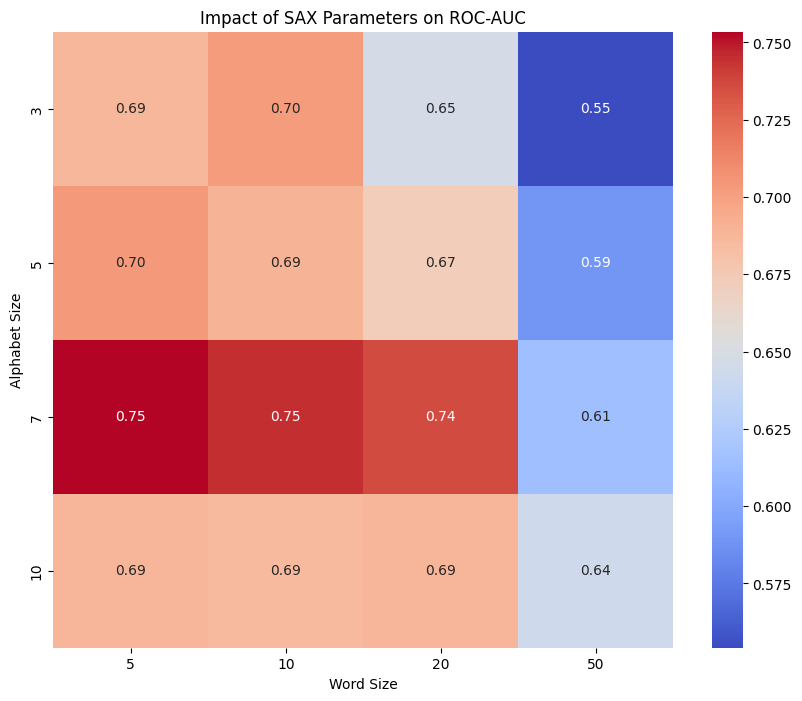

In [38]:
pivot = df_performance.pivot(index='alphabet_size', columns='word_size', values='roc_auc')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Impact of SAX Parameters on ROC-AUC')
plt.xlabel('Word Size')
plt.ylabel('Alphabet Size')
plt.show()


- Impact of Alphabet Size:

**Increasing** the alphabet size **improves** the model's ability to distinguish finer variations in the data.
For smaller alphabet sizes (e.g., 3), the discretization is too coarse, leading to **information loss** and reduced ROC-AUC scores.
At an alphabet size of 7, the model captures a **good balance between granularity and generalization**, which maximizes performance.

- Impact of Word Size:

**Smaller** word sizes (e.g., 5) summarize the time series into very few segments, which **oversimplifies** the data and reduces the model's accuracy.
**Larger** word sizes (e.g., 20) divide the sequence into more segments, preserving temporal details while still benefiting from discretization.
However, **extremely large** word sizes (50) may start introducing **noise or redundancy**, as seen in the slight drop in performance at word size = 50.
